In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, balanced_accuracy_score
import numpy as np


In [49]:
#os.chdir("/storage/" + notebook_dir)
import matplotlib.transforms as transforms
import string
def add_letters(fig, ax, dx=-35/72., dy=15/72.):
    
    letterkwargs = dict(weight='bold', va='top', ha='left', fontsize=8)

    offset = transforms.ScaledTranslation(
            dx, dy, fig.dpi_scale_trans)

    for idx in range(len(ax)):
        ax[idx].text(0, 1, string.ascii_lowercase[idx], transform=ax[idx].transAxes + offset, 
                    **letterkwargs)

def group_auc(df, y_true="y_true", y_pred="y_pred", y_pred_score="y_pred_score"):

    y = df[y_true]
    score = df[y_pred_score]

    try:
        return roc_auc_score(y, score)
    except ValueError:
        return np.nan

def group_acc(df, y_true="y_true", y_pred="y_pred", y_pred_score="y_pred_score"):
    return accuracy_score(df[y_pred], df[y_true])


In [50]:
import pandas as pd

# Mapping true_sg values to (art1, art2)
mapping = {
    0: (0, 0),
    1: (0, 1),
    2: (1, 0),
    3: (1, 1)
}

# subgroup-level results
total_grouped_acc_blind = []
total_grouped_acc_oracle = []
total_test_df_grouped = []

overall_acc = {}

for bias_level in ["0.6", "0.7", "0.8"]:
    df = pd.read_csv("./results/results_hypertag_valtest_{}_clip_imagenet_nslices15_weight10.csv".format(bias_level), index_col=0)
    
    #df["true_sg"] = (df["contamination"] > 0.5) * 1
    df["pred_sg"] = df["sg_gt"]

    # Apply mapping
    df[['pred_art1', 'pred_art2']] = df['pred_sg'].map(mapping).apply(pd.Series)

    test_df_grouped = df[df["split"] == "test"]

    # sample-level results
    df = pd.read_csv("./results/results_persample_hypertag_valtest_{}_clip_imagenet_nslices15_weight10.csv".format(bias_level), index_col=0)


    df["true_subgroup_idx"] = df["true_subgroup_idx"].astype(int)
    df[['art1', 'art2']] = df['true_subgroup_idx'].map(mapping).apply(pd.Series)

    df["y_pred_score"] = df["y_pred"]
    df["y_pred"] = (df["y_pred_score"] > 0.5)*1

    df_test_sample = df[df["split"] == "test"]
    overall_acc[bias_level] = accuracy_score(df_test_sample["y_true"], df_test_sample["y_pred"])

    # add accuracy to group-level table
    grouped_acc_disc = df_test_sample.groupby(["discovered_subgroup_idx"]).apply(group_acc).reset_index(name='acc').set_index("discovered_subgroup_idx")
    test_df_grouped["acc"] = grouped_acc_disc
    test_df_grouped["bias_level"] = bias_level

    # accuracy in ground truth subgroups
    grouped_acc_blind = df_test_sample.groupby(["art1"]).apply(group_acc).reset_index(name='acc_blind')
    grouped_acc_blind["bias_level"] = bias_level
    grouped_acc_oracle = df_test_sample.groupby(["true_subgroup_idx"]).apply(group_acc).reset_index(name='acc_oracle')
    grouped_acc_oracle["bias_level"] = bias_level
    grouped_acc_oracle[['art1', 'art2']] = grouped_acc_oracle['true_subgroup_idx'].map(mapping).apply(pd.Series)

    total_grouped_acc_oracle.append(grouped_acc_oracle)
    total_grouped_acc_blind.append(grouped_acc_blind)
    total_test_df_grouped.append(test_df_grouped)


total_grouped_acc_blind = pd.concat(total_grouped_acc_blind)
total_grouped_acc_oracle = pd.concat(total_grouped_acc_oracle)
total_test_df_grouped = pd.concat(total_test_df_grouped)   

#test_df_grouped

/var/folders/xn/dwgv6q6n5j1bbv3kb2l7nkfr0000gn/T/ipykernel_3875/2873954421.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_acc_disc = df_test_sample.groupby(["discovered_subgroup_idx"]).apply(group_acc).reset_index(name='acc').set_index("discovered_subgroup_idx")
/var/folders/xn/dwgv6q6n5j1bbv3kb2l7nkfr0000gn/T/ipykernel_3875/2873954421.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group

3


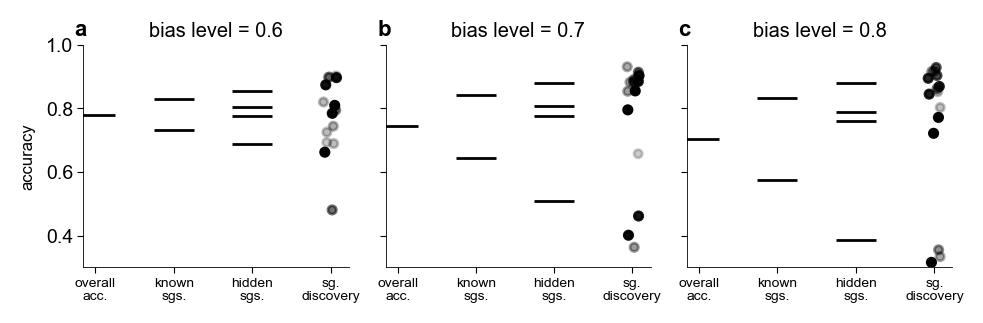

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl

TEXTWIDTH = 12.19826 / 2.54 # for inches
FIGWIDTH = TEXTWIDTH # before 1.5
FIGHEIGHT =  1.5 # before TEXTWIDTH / 3

with plt.style.context("./plot_style.txt"):
    unique_bias_levels = sorted(total_test_df_grouped["bias_level"].unique())
    n_bias_levels = len(unique_bias_levels)
    print(n_bias_levels)
 
    # Create subplots ONCE
    #fig, axes = plt.subplots(1, n_bias_levels, figsize=(1.5 * n_bias_levels, 2), sharey=True, layout='constrained')
    cm = 1/2.54  # centimeters in inches
    # Create subplots ONCE
    textwidth = 12.19826*cm
    fig, axes = plt.subplots(1, n_bias_levels, figsize=(FIGWIDTH, FIGHEIGHT), sharey=True, layout='constrained')
      

    # If there's only one bias level, `axes` won't be a list
    if n_bias_levels == 1:
        axes = [axes]  # make it iterable
    
    x_positions = [0, 1, 2, 3]
    x_labels = [
        "overall\nacc.",
        "known\nsgs.",
        "hidden\nsgs.",
        "sg.\ndiscovery",
    ]
    
    # Optionally define marker/line styles:
    blind_color = "gray"
    oracle_color1 = "blue"   # "oracle w/ artifact2"
    oracle_color2 = "red"    # "oracle w/o artifact2"


    for i, bias_val in enumerate(unique_bias_levels):
        # subset your data
        subset = total_test_df_grouped[total_test_df_grouped["bias_level"] == bias_val]
 
        # pick the i-th Axes
        ax = axes[i]

        # --- 1) overall accuracy (single value) ---
        y_overall = overall_acc[bias_val]  # from your dictionary
        ax.scatter(
            x_positions[0],
            y_overall,
            marker="_",
            s=200,
            linewidths=1,
            color="black",
            #color="gray",
            #label="overall accuracy" if i == 0 else None,
        )

        # known subgroups
        grouped_subset_blind = total_grouped_acc_blind[total_grouped_acc_blind["bias_level"] == bias_val]
        #print(grouped_subset_blind)
        # Plot the first dataset (blind accuracy)
        ax.scatter(
            y=grouped_subset_blind["acc_blind"],
            x=np.ones(len(grouped_subset_blind)) * x_positions[1],
            marker="_",
            s=200,
            linewidths=1,
            color="black",
            #color=["blue","red"]  # Set specific color
        )
        # hidden stratifications
        grouped_subset_oracle = total_grouped_acc_oracle[total_grouped_acc_oracle["bias_level"] == bias_val]

        ax.scatter(
            y=grouped_subset_oracle["acc_oracle"],
            x=np.ones(len(grouped_subset_oracle)) * x_positions[2],
            marker="_",
            linewidths=1,
            s=200,
            color='black'
            # color=["blue","darkblue","magenta","red"]  # Set specific color
        )

        # sg discovery
        subset = total_test_df_grouped[total_test_df_grouped["bias_level"] == bias_val]
        # replicate your plot
        x_pos = np.ones(len(subset)) * x_positions[3]
        y_values = subset["acc"]
 
        # Add jitter
        jitter_strength = 0.1
        x_jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(x_pos))
        x_jittered = np.array(x_pos) + x_jitter
 
        # Decide alpha
        alphas = subset["sg_gt_prob"] ** 2
 
        # Scatter
        ax.scatter(
            x_jittered,
            y_values,
            alpha=alphas,
            color="black"
        )
        

        # --- Tidy up each subplot ---
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels, ha="center", fontsize=5)
        ax.set_ylim(0.3, 1.0)
        if i == 0:
            ax.set_ylabel("accuracy")
        else:
            ax.set_ylabel(None)
        ax.set_title(f"bias level = {bias_val}")
        
        # You can hide the top and right spines, etc.
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    
    # Put a legend on the first axis
    # (We used label=... only on i == 0 above)
    #axes[0].legend(frameon=False, loc="best")
    add_letters(fig, axes, dx=-FIGHEIGHT*n_bias_levels/72. + 0.02, dy=9/72) 
    plt.savefig("l2_blindoracle_v2.pdf")

    plt.show()

3


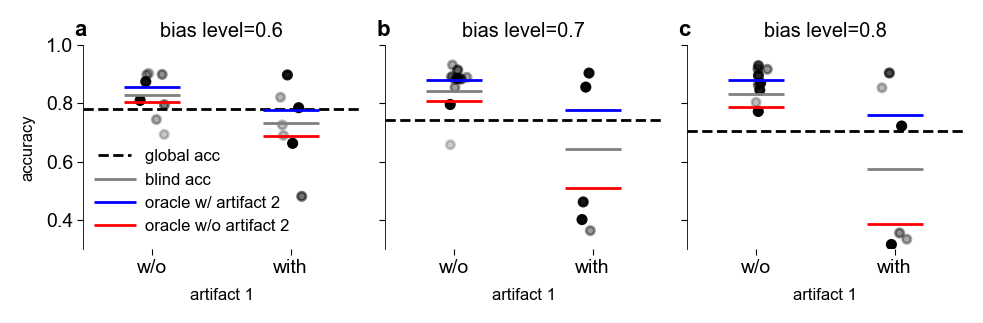

In [ ]:
# Tim's version

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl

FIGHEIGHT = 1.5 # before 2
TEXTWIDTH = 12.19826 / 2.54 # for inches
FIGWIDTH = TEXTWIDTH 

with plt.style.context("./plot_style.txt"):
    unique_bias_levels = sorted(total_test_df_grouped["bias_level"].unique())
    n_bias_levels = len(unique_bias_levels)
    print(n_bias_levels)
 
    # Create subplots ONCE
    #fig, axes = plt.subplots(1, n_bias_levels, figsize=(FIGWIDTH * n_bias_levels, FIGHEIGHT), sharey=True, layout='constrained')
    fig, axes = plt.subplots(1, n_bias_levels, figsize=(FIGWIDTH, FIGHEIGHT), sharey=True, layout='constrained')
    # If there's only one bias level, `axes` won't be a list
    if n_bias_levels == 1:
        axes = [axes]  # make it iterable
        
    for i, bias_val in enumerate(unique_bias_levels):
 
        # pick the i-th Axes
        ax = axes[i]
 

        ax.axhline(y=overall_acc[bias_val], color='black', linestyle='--', linewidth=1)

        subset = total_test_df_grouped[total_test_df_grouped["bias_level"] == bias_val]
        # replicate your plot
        categories = sorted(subset["pred_art1"].unique())
        cat_to_x = {cat: idx for idx, cat in enumerate(categories)}
 
        x_positions = [cat_to_x[cat] for cat in subset["pred_art1"]]
        y_values = subset["acc"]
 
        # Add jitter
        jitter_strength = 0.1
        x_jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(x_positions))
        x_jittered = np.array(x_positions) + x_jitter
 
        # Decide alpha
        alphas = subset["sg_gt_prob"] ** 2
 
        # Scatter
        ax.scatter(
            x_jittered,
            y_values,
            alpha=alphas,
            color="black"
        )
 
        # Tidy up
        category_label_map = {0: "w/o", 1: "with"}
        ax.set_xticks(range(len(categories)))
        ax.set_xticklabels([category_label_map[cat] for cat in categories])
        ax.set_ylim(0.3, 1)
 
        if i == 0:
            ax.set_ylabel("accuracy")
        else:
            ax.set_ylabel(None)
 
        ax.set_xlabel("artifact 1")
        ax.set_title(f"bias level={bias_val}")
 
        # Optional: pointplot for aggregated data, similarly subset
        grouped_subset_blind = total_grouped_acc_blind[total_grouped_acc_blind["bias_level"] == bias_val]
        #print("blind", grouped_subset_blind)
 
 
        # Define colors
        blind_color = "gray"  # Color for blind accuracy
        oracle_color1 = "blue"  # Color for first oracle type
        oracle_color2 = "red"   # Color for second oracle type
 
        # Plot the first dataset (blind accuracy)
        if i == 0:
            sns.pointplot(
                data=grouped_subset_blind,
                y="acc_blind",
                x="art1",  
                linestyle="none",
                errorbar=None,
                marker="_",
                markersize=20,
                markeredgewidth=1,
                ax=ax,
                color=blind_color  # Set specific color
            )
 
            # Create a custom legend entry for the blind accuracy line
            overall_legend = mpl.lines.Line2D(
                [], [], color="black", markersize=15, linestyle="--", linewidth=1, label="Overall Accuracy"
            )

            blind_legend = mpl.lines.Line2D(
                [], [], color=blind_color, marker="_", markersize=15, linestyle="None", label="Blind Accuracy"
            )
 
        else:
            sns.pointplot(
                data=grouped_subset_blind,
                y="acc_blind",
                x="art1",  
                linestyle="none",
                errorbar=None,
                marker="_",
                markersize=20,
                markeredgewidth=1,
                ax=ax,
                color=blind_color
            )
 
        # Plot the second dataset (oracle accuracy)
        grouped_subset_oracle = total_grouped_acc_oracle[total_grouped_acc_oracle["bias_level"] == bias_val]
 
        if i == 0:
            sns.pointplot(
                data=grouped_subset_oracle,
                y="acc_oracle",
                x="art1",  
                hue="art2",  # This generates different colors per category
                dodge=False,
                linestyle="none",
                errorbar=None,
                marker="_",
                markersize=20,
                markeredgewidth=1,
                ax=ax,
                legend=False,
                palette={grouped_subset_oracle["art2"].unique()[0]: oracle_color1,
                        grouped_subset_oracle["art2"].unique()[1]: oracle_color2}  # Assign colors manually
            )
 
            # Create two custom legend handles for the oracle accuracy
            oracle_legend_1 = mpl.lines.Line2D(
                [], [], color=oracle_color1, marker="_", markersize=15, linestyle="None",
            )
            oracle_legend_2 = mpl.lines.Line2D(
                [], [], color=oracle_color2, marker="_", markersize=15, linestyle="None",
            )
 
            # Get existing legend handles and labels
            handles, labels = ax.get_legend_handles_labels()
            
            # Add the custom legend entries
            handles.extend([overall_legend, blind_legend, oracle_legend_1, oracle_legend_2])
            labels.extend(["global acc", "blind acc", "oracle w/ artifact 2", "oracle w/o artifact 2"])
 
            # Set the updated legend
            ax.legend(handles, labels, loc="best", frameon=False)
 
        else:
            sns.pointplot(
                data=grouped_subset_oracle,
                y="acc_oracle",
                x="art1",  
                hue="art2",
                dodge=False,
                linestyle="none",
                errorbar=None,
                marker="_",
                markersize=20,
                markeredgewidth=1,
                ax=ax,
                legend=False,
                palette={grouped_subset_oracle["art2"].unique()[0]: oracle_color1,
                        grouped_subset_oracle["art2"].unique()[1]: oracle_color2}  # Assign colors manually
            )
 
 
        ax.spines['bottom'].set_visible(False)
    # Create subletters
    add_letters(fig, axes, dx=-FIGHEIGHT*n_bias_levels/72. + 0.02, dy=9/72) 
    plt.savefig("l2_blindoracle.pdf")
    plt.show()